In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import io, os, sys, types
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train = pd.read_csv("bike_demand_train.csv", parse_dates=["rent_time"])
train.shape

(11116440, 8)

In [3]:
test = pd.read_csv("bike_demand_test.csv", parse_dates=["rent_time"])
test.shape

(914400, 8)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11116440 entries, 0 to 11116439
Data columns (total 8 columns):
rent_place_num    int64
rent_time         datetime64[ns]
holder            int64
rent_freq         float64
bef_1             float64
bef_2             float64
bef_3             float64
bef_4             float64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 678.5 MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914400 entries, 0 to 914399
Data columns (total 8 columns):
rent_place_num    914400 non-null int64
rent_time         914400 non-null datetime64[ns]
holder            914400 non-null int64
rent_freq         914400 non-null float64
bef_1             914400 non-null float64
bef_2             914400 non-null float64
bef_3             914400 non-null float64
bef_4             914400 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 55.8 MB


In [6]:
## 불필요 columns drop
def drop_columns(feature,x):
    x.drop(feature, axis = 1, inplace=True)

In [7]:
drop_columns(["rent_time", "holder", "rent_place_num"],train)
drop_columns(["rent_time", "holder", "rent_place_num"],test)

In [8]:
print(train.shape)
print(test.shape)

(11116440, 5)
(914400, 5)


In [9]:
## 하이퍼파라미터 튜닝
tf.set_random_seed(777)

In [27]:
learning_rate= 0.001
total_epoch = 200
batch_size = 8760

In [11]:
n_input = 5 # Number of features 
n_step = 4  # Stride 
n_hidden = 1
n_class = 1

In [ ]:
## Data scaler
def MinMaxScaler(data):
    # 데이터 모든숫자들을 최소 값만큼 뺀다.
    numerator = data - np.min(data, 0)
    # 최대값과 최소 값의 차이(A)를 구한다
    denominator = np.max(data, 0) - np.min(data, 0)
    # 너무 큰 값이 나오지 않도록 나눈다
    return numerator / (denominator + 1e-7)

In [12]:
#train = MinMaxScaler(train)
x_pd = train
y_pd = train.loc[:,["rent_freq"]]
tx_pd = test
ty_pd = test.loc[:,["rent_freq"]]

In [13]:
X_train= x_pd.as_matrix()
y_train= y_pd.as_matrix().reshape([len(train),n_class])
X_test= tx_pd.as_matrix()
y_test= ty_pd.as_matrix().reshape([len(test),n_class])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [14]:
## Build train dataset
dataX = []
dataY = []
for i in range(0, len(y_pd)- n_step):
    _x = X_train[i: i + n_step]
    _y = y_train[i + n_step]
    if i is 0:
        print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

[[2. 2. 2. 1. 2.]
 [0. 2. 2. 2. 1.]
 [0. 0. 2. 2. 2.]
 [1. 0. 0. 2. 2.]] -> [0.]


In [15]:
## Build test data set 
dataXt = []
dataYt = []
for i in range(0, len(ty_pd)- n_step):
    _xt = X_test[i: i + n_step]
    _yt = y_test[i + n_step]
    if i is 0:
        print(_xt, "->", _yt)
    dataXt.append(_xt)
    dataYt.append(_yt)

[[1. 2. 7. 3. 1.]
 [3. 1. 2. 7. 3.]
 [2. 3. 1. 2. 7.]
 [1. 2. 3. 1. 2.]] -> [0.]


In [16]:
train_size= int(len(dataY) * 1.0)
test_size = int(len(dataYt)* 1.0)

trainX, testX =np.array(dataX[0:train_size]), np.array(dataXt[0:test_size])
trainY, testY =np.array(dataY[0:train_size]), np.array(dataYt[0:test_size])

In [17]:
X = tf.placeholder(tf.float32, [None,n_step,n_input])
print("X", X)
Y = tf.placeholder(tf.float32, [None,n_class])
print("Y", Y)

X Tensor("Placeholder:0", shape=(?, 4, 5), dtype=float32)
Y Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


In [18]:
targets = tf.placeholder(tf.float32,[None,n_class])
predictions = tf.placeholder(tf.float32,[None,n_class])

In [19]:
## lstm cell 생성
def lstm_cell():
    # LSTM셀을 생성한다.
    # num_units: 각 Cell 출력 크기
    # forget_bias: The bias added to forget gates.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    # cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.sigmoid)
    # cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_hidden, forget_bias=0.8, state_is_tuple=True, activation=tf.tanh)
    return cell

In [20]:
## 1 cell layer 모델
multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(1)], state_is_tuple=True)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [21]:
## lstm output
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 4, 1), dtype=float32)


In [22]:
Y_pred = tf.contrib.layers.fully_connected(hypothesis[:, -1], n_class, activation_fn=None)

In [23]:
loss = tf.reduce_sum(tf.square(Y_pred - Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [ ]:
#is_correct = tf.equal(Y_pred,Y, dtype=tf.float32)
#accuracy = tf.reduce_mean(tf.cast(is_correct))

In [24]:
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [25]:
## 베치 생성자
epochs_completed = 0
index_in_epoch = 0
num_examples = trainX.shape[0]
    # for splitting out batches of data
def next_batch(batch_size):

    global trainX
    global trainY
    global index_in_epoch
    global epochs_completed

    start = index_in_epoch
    index_in_epoch += batch_size

    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        trainX = trainX[perm]
        trainY = trainY[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return trainX[start:end], trainY[start:end]

Epoch: 0002 Avg cost = 14833.29777
Epoch: 0003 Avg cost = 12914.58850
Epoch: 0004 Avg cost = 12559.96763
Epoch: 0005 Avg cost = 12334.16005
Epoch: 0006 Avg cost = 12131.26225
Epoch: 0007 Avg cost = 12036.43158
Epoch: 0008 Avg cost = 11947.42957
Epoch: 0009 Avg cost = 11879.80549
Epoch: 0010 Avg cost = 11810.42812
Epoch: 0011 Avg cost = 11781.39180
Epoch: 0012 Avg cost = 11742.36291
Epoch: 0013 Avg cost = 11705.51461
Epoch: 0014 Avg cost = 11688.35941
Epoch: 0015 Avg cost = 11659.44880
Epoch: 0016 Avg cost = 11661.75936
Epoch: 0017 Avg cost = 11610.14010
Epoch: 0018 Avg cost = 11570.95401
Epoch: 0019 Avg cost = 11549.09358
Epoch: 0020 Avg cost = 11546.70809
Epoch: 0021 Avg cost = 11561.72908
Epoch: 0022 Avg cost = 11485.88941
Epoch: 0023 Avg cost = 11489.21051
Epoch: 0024 Avg cost = 11482.99668
Epoch: 0025 Avg cost = 11467.71989
Epoch: 0026 Avg cost = 11467.69660
Epoch: 0027 Avg cost = 11460.98077
Epoch: 0028 Avg cost = 11420.22399
Epoch: 0029 Avg cost = 11421.76318
Epoch: 0030 Avg cost

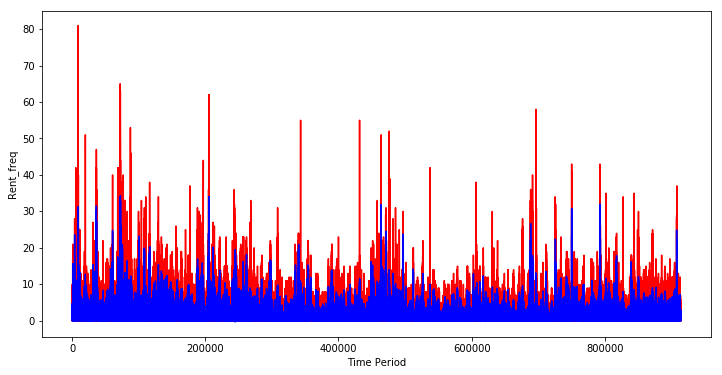

In [28]:
##모델 학습 및 테스트
period = int(X_train.shape[0]/batch_size)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(1,total_epoch+1):
            total_cost = 0
            #generator=batch_generator(batch_size,n_step,n_input) <<2nd batch selecting method
            for i in range(period):
                #batch_xs, batch_ys =next(generator) << 2nd batch selecting method
                batch_xs, batch_ys =next_batch(batch_size)
                # X 데이터를 RNN 입력 데이터에 맞게 [batch_size, n_step, n_input] 형태로 변환합니다.

                _, cost_val = sess.run([train, loss], feed_dict={X: batch_xs, Y: batch_ys})
                total_cost += cost_val

            print('Epoch:', '%04d' % (epoch + 1),
                  'Avg cost =', '{:.5f}'.format(total_cost / period))
            
            
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    np.savetxt('test_predict_lstm.csv', test_predict, delimiter=',', fmt='%d')
    
    # 테스트용 데이터 기준으로 측정지표 rmse를 산출한다
    rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
    print("rmse: ", rmse_val)
    
    plt.figure(figsize=(12,6))
    plt.plot(testY, 'r')
    plt.plot(test_predict, 'b')
    plt.xlabel("Time Period")
    plt.ylabel("Rent_freq")
    plt.show()